In [3]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import cmasher as cmr
import cmocean
import cartopy.crs as ccrs
os.chdir("/home/548/eh6215/python/LagrangianCoherence")
from LCS import LCS
from LCS import trajectory
import cftime
import datetime as dt

In [2]:
path = "/g/data/tp28/dev/barpa/prod/chs548//cg282_ERA5_historical_1979_sciB/{year}{month:02d}01T0000Z/nc/"
fileend = "-ERA-ERA5-historical-r1-barpa_r-v1-"

varlist = {"av_mois_flux_v":("SLV3H",1,"{year}{month:02d}{day:02d}0130-{year}{month:02d}{day:02d}2230"),
           "av_mois_flux_u":("SLV3H",1,"{year}{month:02d}{day:02d}0130-{year}{month:02d}{day:02d}2230"),
           "ttl_col_q":     ("SLV1H",3,"{year}{month:02d}{day:02d}0100-{year1}{month1:02d}{day1:02d}0000")}

outpath = "/scratch/tp28/eh6215/Lagrangian/"

calendar='gregorian'

In [5]:
def compute_trajectories(date):
    date1 = date + dt.timedelta(1)
    data = {}
    for var in varlist:
        stream,k,datestr = varlist[var]
        data[var]=xr.load_dataset((path+stream+'/'+var+fileend+datestr+".nc").format(year=date.year,month=date.month,day=date.day,year1=date1.year,month1=date1.month,day1=date1.day))[var]


    q=data["ttl_col_q"][:].resample(time='3H',loffset='1.5H').interpolate('linear')
    u = data["av_mois_flux_u"][:4,::,::]/q[:4,::,::]
    v = data["av_mois_flux_v"][:4,::,::]/q[:4,::,::]

    u.name = "u"
    v.name = "v"
    ds = xr.merge([u,v])
    ds = ds.reset_coords(drop=True)

    lon = ds.longitude.values
    ds =ds.drop('longitude')
    ds=ds.assign_coords({'longitude':lon-30})

    acs = LCS.LCS(timestep=-3 * 3600, timedim='time', SETTLS_order=1, )
    ftle_a, vec1,vec2,ratio = acs(ds.copy(), isglobal=False, )
#    ftle_a = np.log(ftle_a) / 2
    ftle_a.name = "ftle_a"
    vec1.name = 'eigenvector_x'
    vec2.name = 'eigenvector_y'
    ratio.name = 'ratio'
    out = [ftle_a,vec1,vec2,ratio]
    return out

In [9]:
def compute(year,month):
    if calendar == 'gregorian' or '365' in calendar:
        days = [31,28,31,30,31,30,31,31,30,31,30,31][month-1]
        if calendar=='gregorian':
            if month==2 and year%4==0 and year != 2100:
                days +=1
    elif '360' in calendar:
        days=30
    else:
        exit('no such calendar')
    data = []
    for day in range(days):
        print(day+1)
        date = cftime.datetime(year,month,day+1,calendar=calendar)
        data += compute_trajectories(date)
    ds = xr.merge(data)
    lon = ds.longitude.values
    ds =ds.drop('longitude')
    ds=ds.assign_coords({'longitude':lon+30})
    ds.to_netcdf(outpath+'ACCESS-CM2_historical_%04d%02d.nc'%(year,month))

In [14]:
compute(1980,1)
"""
k=5
ds2 = xr.merge([u[:,::k,::k], v[:,::k,::k]])
ds2=ds2.assign_coords({'longitude':lon[::k]-30})

vec=vec.drop('time')
x = vec.isel(derivatives=1)[:,::k,::k]*ftle_a[:,::k,::k]
y = vec.isel(derivatives=0)[:,::k,::k]*ftle_a[:,::k,::k]
x=x.drop('derivatives')
y=y.drop('derivatives')
x.name = "u"
y.name = "v"
ds3 = xr.merge([x,y])


plt.figure()
ax=plt.subplot(121,projection=ccrs.PlateCarree(30))
ftle_a.isel(time=0).plot.contourf(levels=20,vmin=0,vmax=2,cmap='cubehelix_r')
ds3.isel(time=0).plot.quiver('longitude', 'latitude', 'u', 'v')
ax.coastlines()

ax=plt.subplot(122,projection=ccrs.PlateCarree(30))
div.isel(time=0).plot.contourf(levels=20,vmin=-3,vmax=0,cmap='cubehelix')
ds2.isel(time=0).plot.quiver('longitude', 'latitude', 'u', 'v')
ax.coastlines()
plt.show()

"""

1
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
using s = 30.8696241e6
*---- Parcel propagation ----*
Propagating time 315549000000000000
SETTLS iteration 0
SETTLS iteration 1
SETTLS iteration 2
SETTLS iteration 3
*---- Computing deformation tensor ----*
*---- Computing eigenvalues ----*
*---- Done eigenvalues ----*
2
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
using s = 28.4158411e6
*---- Parcel propagation ----*
Propagating time 315635400000000000
SETTLS iteration 0
SETTLS iteration 1
SETTLS iteration 2
SETTLS iteration 3
*---- Computing deformation tensor ----*
*---- Computing eigenvalues ----*
*---- Done eigenvalues ----*
3
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
using s = 26.9526961e6
*---- Parcel propagation ----*
Propagating time 315721800000000000
SETTLS iteration 0
SETTLS iteration 1
SETTLS iteration 2
SETT

'\nk=5\nds2 = xr.merge([u[:,::k,::k], v[:,::k,::k]])\nds2=ds2.assign_coords({\'longitude\':lon[::k]-30})\n\nvec=vec.drop(\'time\')\nx = vec.isel(derivatives=1)[:,::k,::k]*ftle_a[:,::k,::k]\ny = vec.isel(derivatives=0)[:,::k,::k]*ftle_a[:,::k,::k]\nx=x.drop(\'derivatives\')\ny=y.drop(\'derivatives\')\nx.name = "u"\ny.name = "v"\nds3 = xr.merge([x,y])\n\n\nplt.figure()\nax=plt.subplot(121,projection=ccrs.PlateCarree(30))\nftle_a.isel(time=0).plot.contourf(levels=20,vmin=0,vmax=2,cmap=\'cubehelix_r\')\nds3.isel(time=0).plot.quiver(\'longitude\', \'latitude\', \'u\', \'v\')\nax.coastlines()\n\nax=plt.subplot(122,projection=ccrs.PlateCarree(30))\ndiv.isel(time=0).plot.contourf(levels=20,vmin=-3,vmax=0,cmap=\'cubehelix\')\nds2.isel(time=0).plot.quiver(\'longitude\', \'latitude\', \'u\', \'v\')\nax.coastlines()\nplt.show()\n\n'

In [6]:
a = compute_trajectories(dt.datetime(1980,1,10))

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
using s = 28.9802381e6
*---- Parcel propagation ----*
Propagating time 316348200000000000
SETTLS iteration 0
Propagating time 316337400000000000
SETTLS iteration 0
Propagating time 316326600000000000
SETTLS iteration 0
*---- Computing deformation tensor ----*
*---- Computing eigenvalues ----*
*---- Done eigenvalues ----*


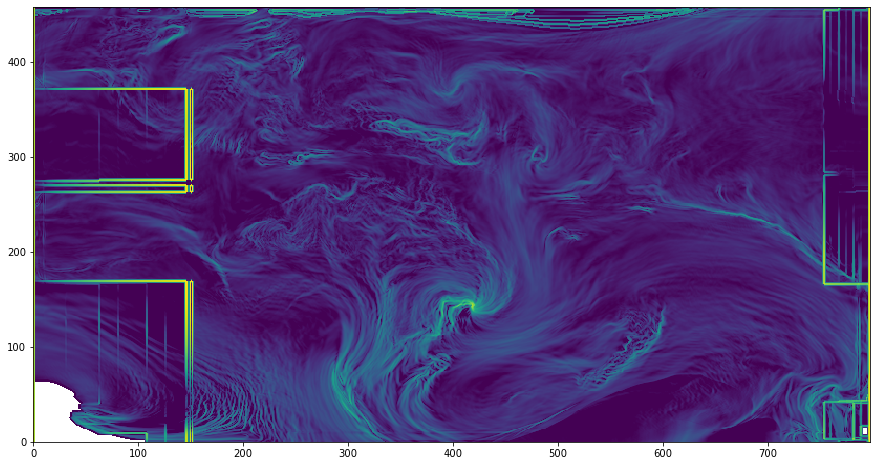

In [9]:
plt.figure(figsize=(15,8))

plt.pcolormesh(a[0][0].data,norm=LogNorm(1,100))

In [8]:
from matplotlib.colors import LogNorm

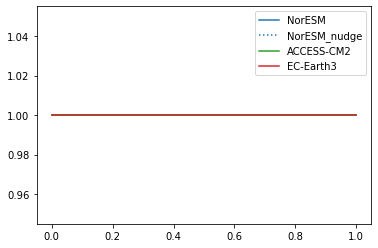

In [1]:
import matplotlib.pyplot as plt

plt.plot([1,1],color='tab:blue',label='NorESM')
plt.plot([1,1],":",color='tab:blue',label='NorESM_nudge')
plt.plot([1,1],color='tab:green',label='ACCESS-CM2')
plt.plot([1,1],color='tab:red',label='EC-Earth3')
plt.legend()